In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

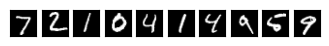

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

n = 10  # how many records we will display
plt.figure(figsize=(4, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

![image.png](attachment:image.png)

In [3]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, UpSampling2D, Reshape, BatchNormalization, MaxPooling2D

In [4]:
# Encoder
encoder = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='valid'),
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.2),
    Dense(64, activation="relu"),
])

2024-04-28 22:47:39.488299: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-04-28 22:47:39.488337: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-28 22:47:39.488346: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-28 22:47:39.488784: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-28 22:47:39.489063: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
decoder = Sequential([
    Dense(128, activation="relu", input_shape=(64,)),
    Dropout(0.2),
    Dense(7*7*128, activation="relu"),
    Reshape((7, 7, 128)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    UpSampling2D((2, 2)),  # First upsampling
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    UpSampling2D((2, 2)),  # Second upsampling
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(1, (3, 3), activation='sigmoid', padding='same'),  # Ensure final layer matches input dimension
])

In [6]:
autoencoder = Sequential([encoder, decoder])

In [7]:
autoencoder.compile(optimizer='Adam', loss='binary_crossentropy')

In [8]:
autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64)                249408    
                                                                 
 sequential_1 (Sequential)   (None, 28, 28, 1)         1058433   
                                                                 
Total params: 1307841 (4.99 MB)
Trainable params: 1306945 (4.99 MB)
Non-trainable params: 896 (3.50 KB)
_________________________________________________________________


In [9]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 64)        256       
 chNormalization)                                                
                                                        

In [10]:
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 6272)              809088    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 128)         147584    
                                                                 
 batch_normalization_3 (Bat  (None, 7, 7, 128)         512       
 chNormalization)                                                
                                                      

In [11]:
x_train = x_train.reshape(60000,28,28,1)
x_train = x_train/255
x_train.shape

(60000, 28, 28, 1)

In [12]:
x_test = x_test.reshape(10000, 28, 28, 1)
x_test = x_test/255
x_test.shape

(10000, 28, 28, 1)

In [13]:
# Callbacks for early stopping and model checkpointing
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10),
    ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)
]

In [14]:
# Train the model
history = autoencoder.fit(x=x_train, y=x_train,  epochs=100, batch_size=256, shuffle=True, verbose=1, validation_data=(x_test, x_test), callbacks = callbacks)


Epoch 1/100


2024-04-28 22:47:50.484429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - ETA: 0s - loss: 0.2024

2024-04-28 22:48:21.608492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 33s 119ms/step - loss: 0.2024 - val_loss: 0.1858
Epoch 2/100
  1/235 [..............................] - ETA: 22s - loss: 0.1304

/Users/chaitanyapavan/anaconda3/envs/tf_env/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


235/235 [==============================] - 26s 112ms/step - loss: 0.1179 - val_loss: 0.1084
Epoch 3/100
235/235 [==============================] - 26s 110ms/step - loss: 0.1094 - val_loss: 0.1004
Epoch 4/100
235/235 [==============================] - 26s 110ms/step - loss: 0.1051 - val_loss: 0.0911
Epoch 5/100
235/235 [==============================] - 26s 111ms/step - loss: 0.1025 - val_loss: 0.0894
Epoch 6/100
235/235 [==============================] - 26s 112ms/step - loss: 0.1007 - val_loss: 0.0883
Epoch 7/100
235/235 [==============================] - 26s 110ms/step - loss: 0.0992 - val_loss: 0.0863
Epoch 8/100
235/235 [==============================] - 26s 110ms/step - loss: 0.0982 - val_loss: 0.0877
Epoch 9/100
235/235 [==============================] - 26s 112ms/step - loss: 0.0974 - val_loss: 0.0851
Epoch 10/100
235/235 [==============================] - 26s 111ms/step - loss: 0.0964 - val_loss: 0.0850
Epoch 11/100
235/235 [==============================] - 26s 112ms/step - lo

In [15]:
decoded_imgs = autoencoder.predict(x_test)


  7/313 [..............................] - ETA: 2s  

2024-04-28 23:03:39.059298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 3s 9ms/step


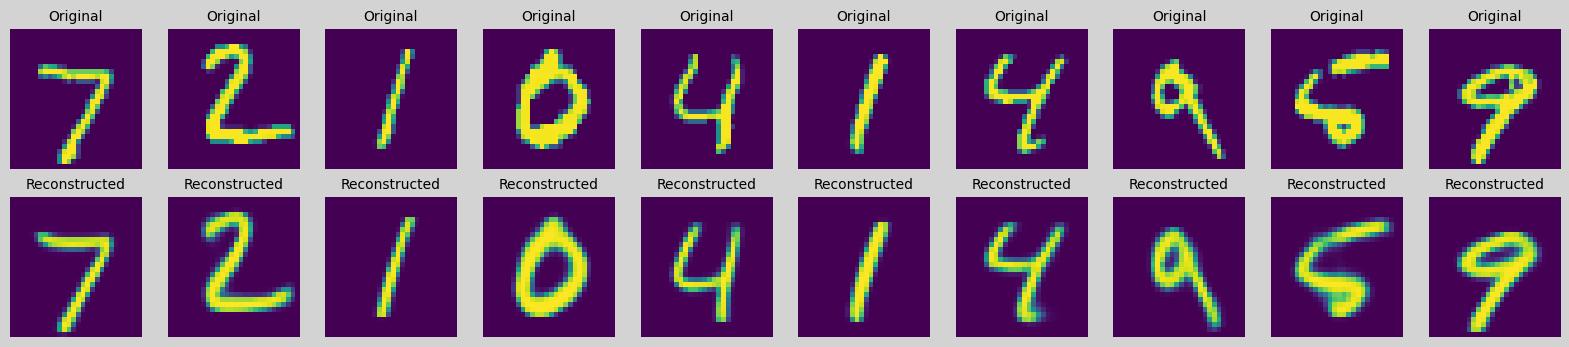

In [16]:
n = 10

# Create a figure with specific background and edge colors
plt.figure(figsize=(20, 4), facecolor='lightgray', edgecolor='darkgray')

for i in range(n):
    # Display original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='viridis')  
    plt.title("Original", fontsize=10)  
    ax.set_aspect(aspect='auto')  
    plt.axis('off')  

    # Display reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='viridis')  
    plt.title("Reconstructed", fontsize=10)  
    ax.set_aspect(aspect='auto') 
    plt.axis('off')  

plt.show()

313/313 [==============================] - 3s 10ms/step


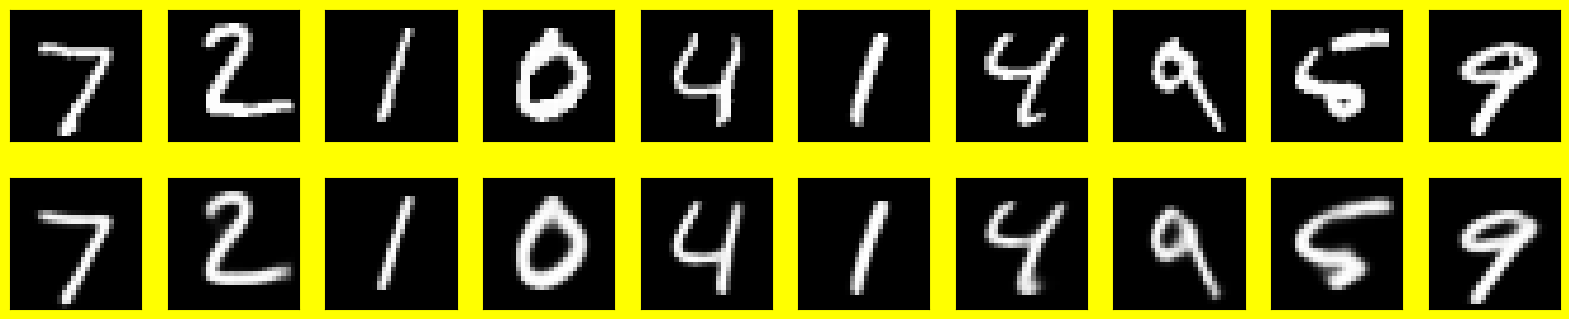

In [18]:
decoded_imgs = autoencoder.predict(x_test)

n = 10

plt.figure(figsize=(20, 4), facecolor='yellow', edgecolor='blue')
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


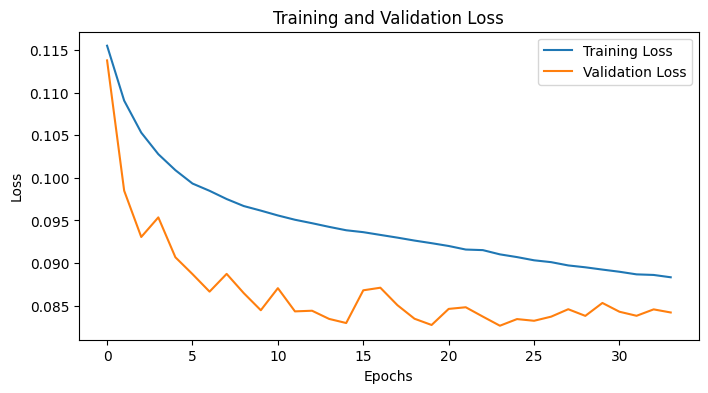

In [19]:
# Plotting the training and validation loss
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()